In [1]:
elastic_rods_dir = '../../../../../elastic_rods/python/'
weaving_dir = '../../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_fixed_boundary_joint)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.06775294400510493
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('hanging_lamp_1', thickness, width, weaving_dir)
#  [ ear 396, ear 412, nose 497]

0.02258431466836831 0.0015809020267857816


In [4]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 0.01
sw = 0.01

In [5]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [6]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/hanging_lamp_1/hanging_lamp_1_dof.npy'))

In [7]:
rw = 0.001

In [8]:
iterateData = stage_1_optimization(curved_linkage, rw, sw, curved_linkage_view)

In [7]:
fixed_boundary_joints = get_fixed_boundary_joint(curved_linkage)

In [8]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [11]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = fixed_boundary_joints)

0	4.93385e-05	0.00013291	0.00013291	1	1
1	4.88051e-05	0.00743523	0.00743523	1	1
2	4.84669e-05	0.000173693	0.000173693	1	0
3	4.81789e-05	0.0016988	0.0016988	1	0
4	4.8092e-05	2.13178e-05	2.13178e-05	1	0
5	4.80915e-05	1.78288e-05	1.78288e-05	1	0
6	4.80915e-05	7.03353e-09	7.03353e-09	1	0


In [10]:
curved_linkage.attraction_weight = 1e-7

In [ ]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, fixed_boundary_joint = fixed_boundary_joints)

In [ ]:
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -5, 3)

In [ ]:
curved_optimizer_energy = curved_linkage.energy()
validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
validation_curved_linkage.attraction_weight = 1e-7
with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = fixed_boundary_joints)
validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
validation_curved_energy = validation_curved_linkage.energy()
print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

In [ ]:
validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
set_surface_view_options(validation_curved_view)
validation_curved_view.show()

In [ ]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(validation_curved_linkage)

In [ ]:
set_joint_vector_field(validation_curved_linkage, validation_curved_view, deviation_vector)

Min Width  0.02258431466836831
Scale:  221.3925936394706
num seg per rod 8
num seg per rod 98
num seg per rod 98
num seg per rod 98
num seg per rod 8
num seg per rod 98
num seg per rod 8
num seg per rod 98
num seg per rod 8
num seg per rod 8
num seg per rod 98
num seg per rod 98
num seg per rod 8
num seg per rod 8
num seg per rod 98
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8
num seg per rod 8

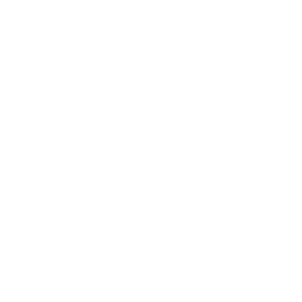

In [12]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
os.chdir(save_path)

In [ ]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()